In [223]:
import json
import pickle
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.cm as cm
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Use Times Roman font style for plt plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'serif']

from utils.signal_processing import tukey_window, taper
from utils.geo import haversine_dist, prepare_gic_gdf, get_intersecting_transmission_lines
from scripts.data_loading import (
    load_tva_gic,
    load_tva_magnetometer,
    find_closest_magnetometers_to_gic,
    get_selected_sites,
    load_and_process_transmission_lines
)

# Load results data
results_dir = Path("results")

# Load the summary CSV for quick overview
df_summary = pd.read_csv(results_dir / "model_comparison.csv")
print("Performance Summary:")
print(df_summary)

# Load the full JSON results for detailed analysis
with open(results_dir / "regression_models_results.json", "r") as f:
    full_results = json.load(f)

# Load metadata
with open(results_dir / "run_metadata.json", "r") as f:
    metadata = json.load(f)
    
print(f"\nRun info: {metadata['run_timestamp']}")
print(f"Sites: {metadata['sites_processed']}")

Performance Summary:
               Site      3_TD      3_FD         4  Heyns_TD  Heyns_Ens  \
0          Bull Run  0.745643  0.759551  0.263901  0.782677   0.785814   
1          Paradise  0.930946  0.904922  0.926215  0.931966   0.882484   
2             Union  0.923333  0.787378  0.823390  0.919318   0.757818   
3  Raccoon Mountain  0.744841  0.802485  0.470225  0.777752   0.805677   
4           Average  0.836191  0.813584  0.620933  0.852928   0.807948   

     5a_CNN    5b_GRU  
0  0.243166  0.574843  
1  0.740405  0.860022  
2 -0.229079 -0.006351  
3  0.012818  0.333969  
4  0.191827  0.440621  

Run info: 2025-06-12 18:51:39
Sites: ['Bull Run', 'Paradise', 'Union', 'Raccoon Mountain']


In [216]:
# Load the raw data
print("Loading raw data...")
tva_gic = load_tva_gic()
tva_mag = load_tva_magnetometer()
selected_sites = get_selected_sites()
closest_mag_to_gic = find_closest_magnetometers_to_gic(
    gic_data=tva_gic, mag_data=tva_mag
)
tl_gdf = load_and_process_transmission_lines()

# time periods used in train
train_slice = slice(
    np.datetime64("2024-05-10T00:00:00"), np.datetime64("2024-05-11T00:00:00")
)
test_slice = slice(
    np.datetime64("2024-05-11T12:00:00"), np.datetime64("2024-05-11T18:00:00")
)

duration = slice(np.datetime64("2024-05-10T00:00:00"), np.datetime64("2024-05-11T18:00:00"))

Loading raw data...
2025-06-13 14:13:33,779 - data_loader - INFO - Magnetometer Ackerman: Closest MT site is MSY46 at 37.16 km
2025-06-13 14:13:33,817 - data_loader - INFO - Magnetometer Bull Run: Closest MT site is TNU51 at 25.20 km
2025-06-13 14:13:33,860 - data_loader - INFO - Magnetometer Lagoon Creek: Closest MT site is TNV44 at 37.57 km
2025-06-13 14:13:33,898 - data_loader - INFO - Magnetometer Paradise: Closest MT site is KYS47 at 15.32 km
2025-06-13 14:13:33,932 - data_loader - INFO - Magnetometer Raccoon Mountain: Closest MT site is TNV50 at 39.78 km
2025-06-13 14:13:33,968 - data_loader - INFO - Magnetometer Union: Closest MT site is MSX46 at 20.36 km
2025-06-13 14:13:34,032 - data_loader - INFO - Magnetometer Watts Bar: Closest MT site is TNV50 at 43.02 km
2025-06-13 14:13:54,121 - data_loader - INFO - MT site TNV50: nearest magnetometer Raccoon Mountain (39.78 km).
2025-06-13 14:13:54,127 - data_loader - INFO - GIC Bradley: nearest magnetometer Raccoon Mountain (39.04 km),

In [218]:
# Time window for the storm
start_time = np.datetime64("2024-05-10T15:00:00")
end_time = np.datetime64("2024-05-11T18:00:00")

site = "Bull Run"  # from selected sites

# Get site data
mag_site = closest_mag_to_gic[site]["magnetometer"] 
mt_site = closest_mag_to_gic[site]["mt_site"]

gic_data = tva_gic.gic.sel(device=site, time=slice(start_time, end_time))
mag_data = tva_mag.sel(device=mag_site, time=slice(start_time, end_time))

time_axis = mag_data.time
Bx = mag_data.Bx.values
By = mag_data.By.values

n = len(Bx)
w = tukey_window(n, 0.05)
Ex, Ey = mt_site.convolve_fft(taper(Bx, w), taper(By, w), dt=1.0)

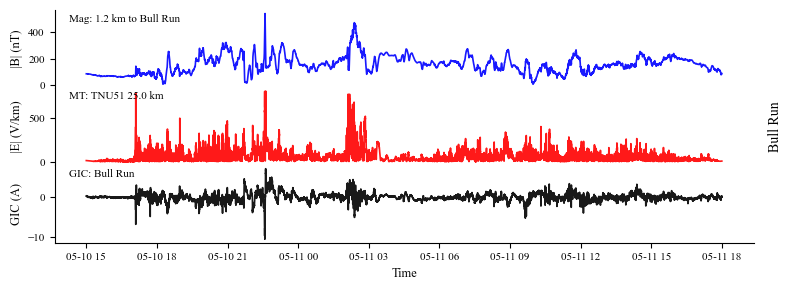

In [224]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 3), sharex=True)

B_mag = np.sqrt(Bx**2 + By**2)
E_mag = np.sqrt(Ex**2 + Ey**2) 

ax1.plot(time_axis, B_mag, 'b-', alpha=0.9, linewidth=1.2)
ax1.set_ylabel('|B| (nT)', fontsize=9)
ax1.tick_params(labelsize=8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(time_axis, E_mag, 'r-', alpha=0.9, linewidth=1.2)
ax2.set_ylabel('|E| (V/km)', fontsize=9)
ax2.tick_params(labelsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(bottom=False)

ax3.plot(gic_data.time, gic_data.values, 'k-', alpha=0.9, linewidth=1.2)
ax3.set_ylabel('GIC (A)', fontsize=9)
ax3.set_xlabel('Time', fontsize=9)
ax3.tick_params(labelsize=8)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

mag_name = closest_mag_to_gic[site]["magnetometer"]
mag_distance = closest_mag_to_gic[site]["distance_to_mag"]
gic_lat = closest_mag_to_gic[site]["lat"]
gic_lon = closest_mag_to_gic[site]["lon"]
mt_site_obj = closest_mag_to_gic[site]["mt_site"]
mt_distance = haversine_dist(gic_lat, gic_lon, mt_site_obj.latitude, mt_site_obj.longitude)

ax1.text(0.02, 0.85, f'Mag: {mag_distance:.1f} km to {mag_name}', transform=ax1.transAxes, fontsize=8)
ax2.text(0.02, 0.85, f'MT: {mt_site_obj.name} {mt_distance:.1f} km', transform=ax2.transAxes, fontsize=8)
ax3.text(0.02, 0.85, f'GIC: {site}', transform=ax3.transAxes, fontsize=8)

ax2.text(1.02, 0.5, site, transform=ax2.transAxes, rotation=90, va='center', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

In [225]:
def extract_site_data(site, start_time, end_time, tva_gic, tva_mag, closest_mag_to_gic):
    """Extract and process data for a single site"""
    # Get site components
    mag_site = closest_mag_to_gic[site]["magnetometer"] 
    mt_site = closest_mag_to_gic[site]["mt_site"]
    
    # Extract data
    gic_data = tva_gic.gic.sel(device=site, time=slice(start_time, end_time))
    mag_data = tva_mag.sel(device=mag_site, time=slice(start_time, end_time))
    
    # Get time axis and B-field components
    time_axis = mag_data.time
    Bx, By = mag_data.Bx.values, mag_data.By.values
    
    # Compute E-fields using MT method
    n = len(Bx)
    w = tukey_window(n, 0.05)
    Ex, Ey = mt_site.convolve_fft(taper(Bx, w), taper(By, w), dt=1.0)
    
    return time_axis, Bx, By, Ex, Ey, gic_data, mt_site

In [226]:
def plot_single_site(axes, time_axis, Bx, By, Ex, Ey, gic_data, site, mt_site, closest_mag_to_gic):
    """
    Plot 3-panel visualization for one site on provided axes
    """
    ax1, ax2, ax3 = axes
    
    # Calculate magnitudes
    B_mag = np.sqrt(Bx**2 + By**2)
    E_mag = np.sqrt(Ex**2 + Ey**2)
    
    # B-field panel (top)
    ax1.plot(time_axis, B_mag, 'b-', alpha=0.9, linewidth=0.8)
    ax1.set_ylabel('|B| (nT)', fontsize=9)
    ax1.tick_params(labelsize=8, bottom=False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    
    # E-field panel (middle)
    ax2.plot(time_axis, E_mag, 'r-', alpha=0.9, linewidth=0.8)
    ax2.set_ylabel('|E| (V/km)', fontsize=9)
    ax2.tick_params(labelsize=8, bottom=False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    # GIC panel (bottom)
    ax3.plot(gic_data.time, gic_data.values, 'k-', alpha=0.9, linewidth=0.8)
    ax3.set_ylabel('GIC (A)', fontsize=9)
    ax3.set_xlabel('Time', fontsize=9)
    ax3.tick_params(labelsize=8)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Calculate distances
    mag_name = closest_mag_to_gic[site]["magnetometer"]
    mag_distance = closest_mag_to_gic[site]["distance_to_mag"]
    gic_lat = closest_mag_to_gic[site]["lat"]
    gic_lon = closest_mag_to_gic[site]["lon"]
    mt_distance = haversine_dist(gic_lat, gic_lon, mt_site.latitude, mt_site.longitude)
    
    # Add labels
    ax1.text(0.02, 0.85, f'Mag: {mag_distance:.1f} km to {mag_name}', transform=ax1.transAxes, fontsize=8)
    ax2.text(0.02, 0.85, f'MT: {mt_site.name} {mt_distance:.1f} km', transform=ax2.transAxes, fontsize=8)
    ax3.text(0.02, 0.85, f'GIC: {site}', transform=ax3.transAxes, fontsize=8)
    
    # Site label on the right
    ax2.text(1.02, 0.5, site, transform=ax2.transAxes, rotation=90, va='center', fontsize=10)

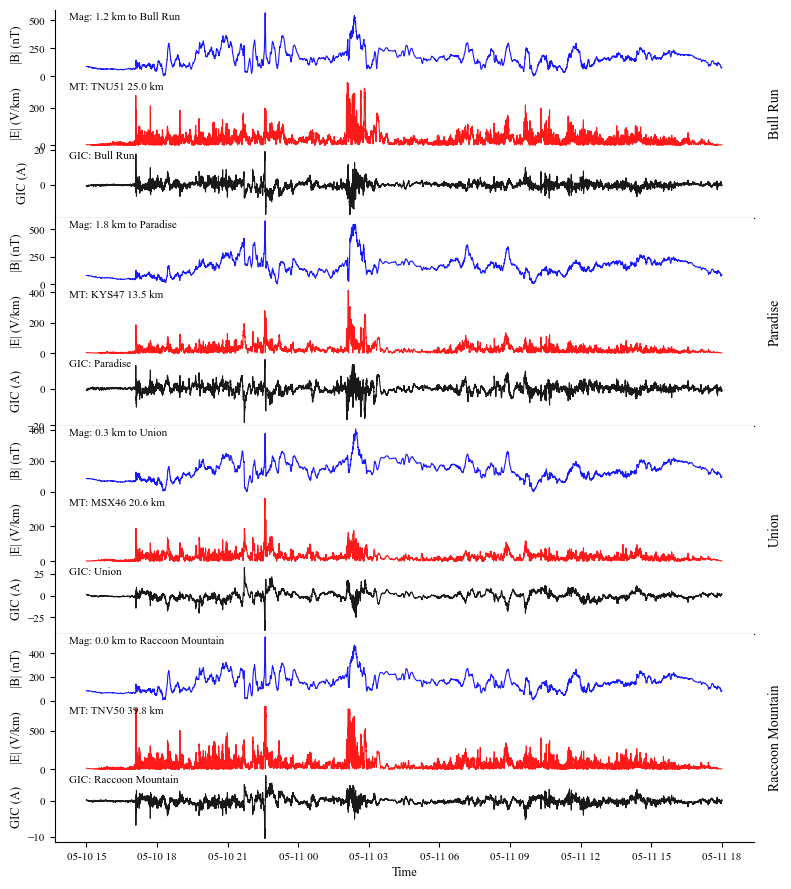

In [227]:
sites_to_plot = ["Bull Run", "Paradise", "Union", "Raccoon Mountain"]
fig, axes = plt.subplots(12, 1, figsize=(8, 9), sharex=True)

# Loop through sites and plot each one
for i, site in enumerate(sites_to_plot):
    # Get the 3 axes for this site (B, E, GIC)
    site_axes = (axes[i*3], axes[i*3+1], axes[i*3+2])
    
    # Extract data for this site
    time_axis, Bx, By, Ex, Ey, gic_data, mt_site = extract_site_data(
        site, start_time, end_time, tva_gic, tva_mag, closest_mag_to_gic
    )
    
    # Plot on the designated axes
    plot_single_site(site_axes, time_axis, Bx, By, Ex, Ey, gic_data, site, mt_site, closest_mag_to_gic)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig("raw_data.pdf", dpi=300, bbox_inches='tight')
plt.show()

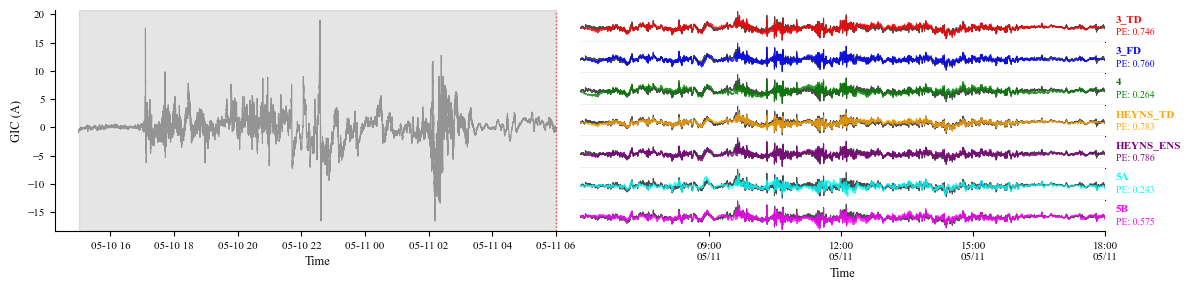

In [228]:
site = "Bull Run"

model_colors = {
    '3_td': 'red', 
    '3_fd': 'blue', 
    '4': 'green', 
    'heyns_td': 'orange',
    'heyns_ens': 'purple',
    '5a': 'cyan',        # CNN
    '5b': 'magenta'      # GRU
}

n_models = len(model_colors)

# Create compact subplot grid
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(n_models, 2, width_ratios=[1, 1], hspace=0, wspace=0)

# Left column: Single training subplot spanning all rows
ax_train = fig.add_subplot(gs[:, 0])

# Training data
train_slice = slice(np.datetime64("2024-05-10T15:00:00"), np.datetime64("2024-05-11T06:00:00"))
train_gic = tva_gic.gic.sel(device=site, time=train_slice)

ax_train.axvspan(train_slice.start, train_slice.stop, alpha=0.2, color='grey')
ax_train.plot(train_gic.time, train_gic.values, 'grey', alpha=0.8, linewidth=0.8)
ax_train.axvline(train_slice.stop, color='red', linestyle=':', alpha=0.7, linewidth=1.0)

ax_train.set_ylabel('GIC (A)', fontsize=9)
ax_train.set_xlabel('Time', fontsize=9)
ax_train.tick_params(labelsize=8)
ax_train.spines['top'].set_visible(False)
ax_train.spines['right'].set_visible(False)

site_results = full_results[site]

model_time_ranges = {}
for model_name in model_colors.keys():
    if model_name in site_results:
        raw_timestamps = site_results[model_name]['test_times']
        test_times = pd.to_datetime([int(ts) for ts in raw_timestamps], unit='ns')
        model_time_ranges[model_name] = {
            'times': test_times,
            'start': test_times[0],
            'end': test_times[-1]
        }

common_start = max([info['start'] for info in model_time_ranges.values()])
common_end = min([info['end'] for info in model_time_ranges.values()])

aligned_data = {}
for model_name in model_colors.keys():
    if model_name in site_results and model_name in model_time_ranges:
        times = model_time_ranges[model_name]['times']
        
        # Find indices for common time window
        start_idx = times.searchsorted(common_start)
        end_idx = times.searchsorted(common_end, side='right')
        
        # Extract data for common window
        aligned_times = times[start_idx:end_idx]
        observations = np.array(site_results[model_name]['observations'])[start_idx:end_idx]
        predictions = np.array(site_results[model_name]['predictions'])[start_idx:end_idx]
        
        aligned_data[model_name] = {
            'times': aligned_times,
            'observations': observations,
            'predictions': predictions,
            'pe': site_results[model_name]['pe']
        }


reference_model = list(aligned_data.keys())[0]
common_times = aligned_data[reference_model]['times']

for i, (model_name, color) in enumerate(model_colors.items()):
    if model_name in aligned_data:
        ax = fig.add_subplot(gs[i, 1])
        
        data = aligned_data[model_name]
        
        # Plot measured (black) and predicted (colored) with thin lines
        ax.plot(data['times'], data['observations'], 'k-', linewidth=0.8, alpha=0.7)
        ax.plot(data['times'], data['predictions'], color, linewidth=0.8, alpha=0.8)
        
        # Model name and PE score to the right
        ax.text(1.02, 0.7, f'{model_name.upper()}', transform=ax.transAxes, 
                fontsize=8, fontweight='bold', color=color, va='center')
        ax.text(1.02, 0.3, f'PE: {data["pe"]:.3f}', transform=ax.transAxes, 
                fontsize=7, color=color, va='center')
        
        # Remove spines for seamless look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        
        # Only show x-axis on bottom subplot
        if i < n_models - 1:
            ax.set_xticklabels([])
            ax.set_xlim(common_times[0], common_times[-1])
            ax.tick_params(bottom=False, left=False, right=False, top=False)
        else:
            ax.set_xlabel('Time', fontsize=9)
            ax.tick_params(labelsize=8, left=False, right=False, top=False)
            # Format time nicely
            ax.set_xlim(common_times[0], common_times[-1])
            ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m/%d'))
            ax.tick_params(axis='x', labelrotation=0)
        
        # No y-axis labels
        ax.set_yticklabels([])
        ax.tick_params(left=False, right=False)

plt.tight_layout()
plt.show()

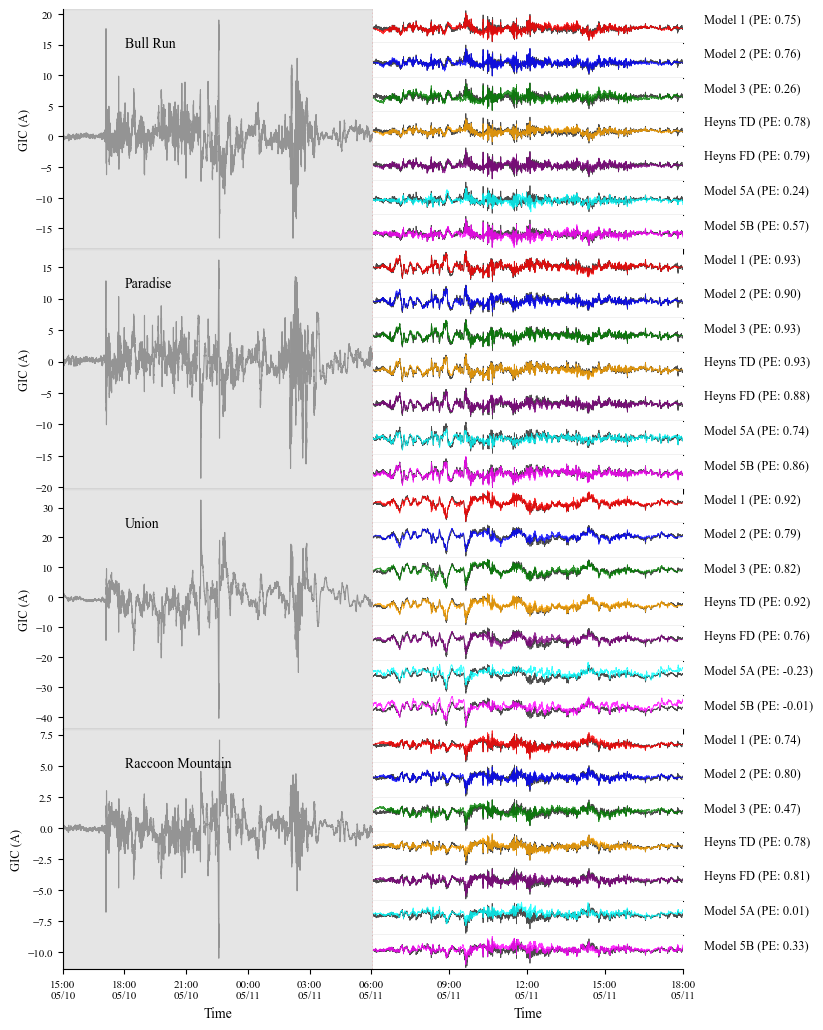

In [229]:
def find_common_time_window(selected_sites, full_results, model_colors):
    """
    Find common time window across all sites and models
    """
    all_starts = []
    all_ends = []
    
    # Collect all time ranges
    for site in selected_sites:
        if site in full_results:
            site_results = full_results[site]
            for model_name in model_colors.keys():
                if model_name in site_results:
                    raw_timestamps = site_results[model_name]['test_times']
                    test_times = pd.to_datetime([int(ts) for ts in raw_timestamps], unit='ns')
                    all_starts.append(test_times[0])
                    all_ends.append(test_times[-1])
    
    # Common window (latest start, earliest end)
    common_start = max(all_starts)
    common_end = min(all_ends)
    
    return common_start, common_end

def plot_single_gic_site(fig, gs_row, site, full_results, tva_gic, model_colors, model_display_names, common_start, common_end, bottom_train_spine=False):
    """
    Plot training + stacked model predictions for one site on provided figure
    """
    n_models = len(model_colors)
    
    # Create GridSpec for this site with NO spacing
    gs_site = fig.add_gridspec(n_models, 2, 
                              width_ratios=[1, 1], 
                              hspace=0, wspace=0,
                              top=0.98 - gs_row * 0.2,
                              bottom=0.98 - (gs_row + 1) * 0.2)
    
    # Left column: Training subplot spanning all model rows
    ax_train = fig.add_subplot(gs_site[:, 0])
    
    # Training data - END EXACTLY where prediction STARTS for seamless connection
    train_slice = slice(np.datetime64("2024-05-10T15:00:00"), common_start)
    train_gic = tva_gic.gic.sel(device=site, time=train_slice)
    
    ax_train.axvspan(train_slice.start, train_slice.stop, alpha=0.2, color='grey')
    ax_train.plot(train_gic.time, train_gic.values, 'grey', alpha=0.8, linewidth=0.8)
    ax_train.axvline(train_slice.stop, color='red', linestyle=':', alpha=0.7, linewidth=1.0)
    
    ax_train.set_ylabel('GIC (A)', fontsize=9)
    ax_train.tick_params(labelsize=8)
    
    # CONSISTENT spine setup
    ax_train.spines['top'].set_visible(False)
    ax_train.spines['right'].set_visible(False)
    ax_train.spines['bottom'].set_visible(True)
    ax_train.spines['left'].set_visible(True)
    ax_train.tick_params(right=False, top=False)
    
    # Control labels and ticks
    if bottom_train_spine:
        ax_train.set_xlabel('Time', fontsize=10)
        ax_train.set_xlim(train_slice.start, train_slice.stop)
        ax_train.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
        ax_train.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m/%d'))
        ax_train.tick_params(axis='x', labelrotation=0)
    else:
        ax_train.set_xlim(train_slice.start, train_slice.stop)
        ax_train.set_xticklabels([])
    
    # Right column: Use common time window for all models
    site_results = full_results[site]
    
    # Get aligned data for each model using common window
    aligned_data = {}
    for model_name in model_colors.keys():
        if model_name in site_results:
            raw_timestamps = site_results[model_name]['test_times']
            times = pd.to_datetime([int(ts) for ts in raw_timestamps], unit='ns')
            
            # Find indices for common time window
            start_idx = times.searchsorted(common_start)
            end_idx = times.searchsorted(common_end, side='right')
            
            # Extract data for common window
            aligned_times = times[start_idx:end_idx]
            observations = np.array(site_results[model_name]['observations'])[start_idx:end_idx]
            predictions = np.array(site_results[model_name]['predictions'])[start_idx:end_idx]
            
            aligned_data[model_name] = {
                'times': aligned_times,
                'observations': observations,
                'predictions': predictions,
                'pe': site_results[model_name]['pe']
            }
    
    for i, (model_name, color) in enumerate(model_colors.items()):
        if model_name in aligned_data:
            ax = fig.add_subplot(gs_site[i, 1])
            
            data = aligned_data[model_name]
            
            # Plot measured (black) and predicted (colored) with thin lines
            ax.plot(data['times'], data['observations'], 'k-', linewidth=0.6, alpha=0.7)
            ax.plot(data['times'], data['predictions'], color, linewidth=0.6, alpha=0.8)
            
            # Model name and PE score to the right - use display name
            display_name = model_display_names.get(model_name, model_name.upper())
            ax.text(1.07, 0.7, f'{display_name} (PE: {data["pe"]:.2f})', transform=ax.transAxes, 
                    fontsize=9, color='k', va='center')
            
            # CONSISTENT spine setup
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            
            # Control labels and ticks
            if i < len(model_colors) - 1:
                ax.set_xticklabels([])
                ax.set_xlim(common_start, common_end)
                ax.tick_params(bottom=False, left=False, right=False, top=False)
            else:
                ax.set_xticklabels([])
                ax.set_xlim(common_start, common_end)

                if bottom_train_spine:
                    ax.set_xlabel('Time', fontsize=10)
                    ax.tick_params(labelsize=8, left=False, right=False, top=False)
                    ax.set_xlim(common_start, common_end)
                    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m/%d'))
                    ax.tick_params(axis='x', labelrotation=0)
            
            # No y-axis labels or ticks
            ax.set_yticklabels([])
            ax.tick_params(left=False, right=False, top=False)
    
    # Site label
    ax.text(-0.8, 6, site, transform=ax.transAxes, va='center', fontsize=10)

model_colors = {
    '3_td': 'red', 
    '3_fd': 'blue', 
    '4': 'green', 
    'heyns_td': 'orange',
    'heyns_ens': 'purple',
    '5a': 'cyan',
    '5b': 'magenta'
}

# Model display names for plots
model_display_names = {
    '3_td': 'Model 1',
    '3_fd': 'Model 2', 
    '4': 'Model 3',
    'heyns_td': 'Heyns TD',
    'heyns_ens': 'Heyns FD',
    '5a': 'Model 5A',
    '5b': 'Model 5B'
}

# Find common time window across ALL sites and models
common_start, common_end = find_common_time_window(selected_sites, full_results, model_colors)

n_sites = len(selected_sites)
last_site = selected_sites[-1]

# Create figure with height
fig = plt.figure(figsize=(8, 12))

# Plot each site with common time window
for i, site in enumerate(selected_sites):
    bottom_train_spine = (site == last_site)
    if site in full_results:
        plot_single_gic_site(fig, i, site, full_results, tva_gic, model_colors, model_display_names,
                           common_start, common_end, bottom_train_spine=bottom_train_spine)

# fig.savefig("preds_h_w.png", dpi=300, bbox_inches='tight')
plt.savefig("preds_h_w.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [230]:
closest_mag_to_gic_filt = {k: v for k, v in closest_mag_to_gic.items() if k in selected_sites}

gic_gdf = prepare_gic_gdf(closest_mag_to_gic_filt)

# Get intersections between GIC sites and transmission lines
intersections_gdf = get_intersecting_transmission_lines(
    gic_gdf, 
    tl_gdf, 
    buffer_distance=150
)

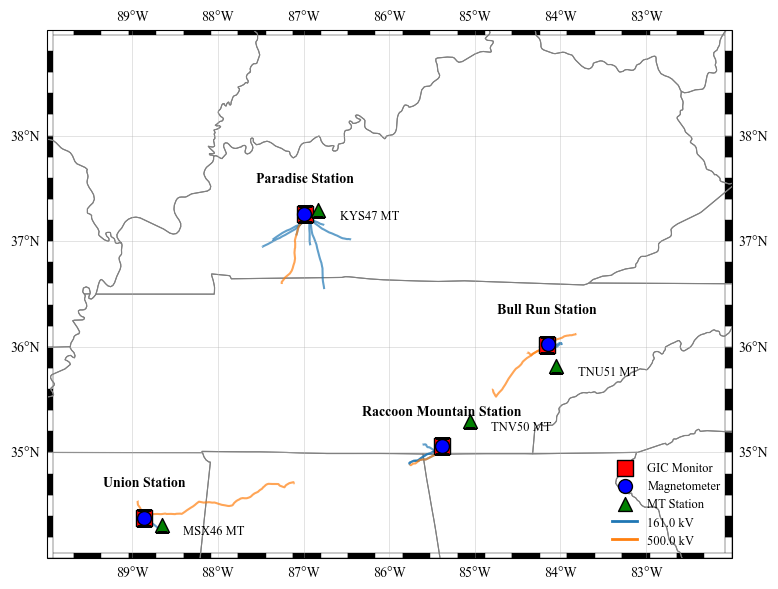

In [234]:
def add_checkered_border(ax, n=25, bar=0.01, lw=0.3):
    """Thin checkered border"""
    step = 1 / n
    trans = ax.transAxes
    for i in range(n):
        c = 'k' if i % 2 else 'w'
        # top & bottom
        ax.add_patch(patches.Rectangle((i*step, 1-bar), step, bar, fc=c, ec='k', lw=lw, transform=trans))
        ax.add_patch(patches.Rectangle((i*step, 0),       step, bar, fc=c, ec='k', lw=lw, transform=trans))
        # left & right
        ax.add_patch(patches.Rectangle((0,       i*step), bar, step, fc=c, ec='k', lw=lw, transform=trans))
        ax.add_patch(patches.Rectangle((1-bar,   i*step), bar, step, fc=c, ec='k', lw=lw, transform=trans))

# Create map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-90, -82, 34, 39], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
add_checkered_border(ax)

# Convert intersections_gdf to EPSG:4326 if needed
if intersections_gdf.crs != 'EPSG:4326':
    intersections_gdf = intersections_gdf.to_crs('EPSG:4326')

# Plot transmission lines colored by voltage (use plasma colormap - better visibility)
voltage_values = intersections_gdf['VOLTAGE'].unique()
voltage_values = sorted([v for v in voltage_values if pd.notna(v)])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
voltage_colors = dict(zip(voltage_values, colors[:len(voltage_values)]))

for voltage in voltage_values:
    voltage_lines = intersections_gdf[intersections_gdf['VOLTAGE'] == voltage]
    voltage_lines.plot(ax=ax, color=voltage_colors[voltage], 
                      linewidth=1.5, alpha=0.7, 
                      transform=ccrs.PlateCarree())

# Plot selected sites
for site in selected_sites:
    gic_lat = closest_mag_to_gic[site]["lat"]
    gic_lon = closest_mag_to_gic[site]["lon"]
    mag_name = closest_mag_to_gic[site]["magnetometer"]
    mt_site_obj = closest_mag_to_gic[site]["mt_site"]
    
    # Get actual magnetometer coordinates
    mag_lat = tva_mag.sel(device=mag_name).latitude
    mag_lon = tva_mag.sel(device=mag_name).longitude
    
    # Plot GIC, magnetometer, and MT sites
    ax.scatter(gic_lon, gic_lat, color='red', marker='s', s=120, edgecolor='black', linewidth=1, zorder=5)
    ax.scatter(mag_lon, mag_lat, color='blue', marker='o', s=100, edgecolor='black', linewidth=1, zorder=5)
    ax.scatter(mt_site_obj.longitude, mt_site_obj.latitude, color='green', marker='^', s=100, edgecolor='black', linewidth=1, zorder=5)
    
    # Labels
    ax.text(gic_lon, gic_lat+0.3, f"{site} Station", ha='center', fontsize=10, fontweight='bold', color='black')
    # ax.text(mag_lon, mag_lat+0.5, mag_name, ha='center', fontsize=8, color='black')
    ax.text(mt_site_obj.longitude+0.6, mt_site_obj.latitude-0.08, f"{mt_site_obj.name} MT", ha='center', fontsize=9, color='black')

# Create comprehensive legend
legend_elements = [
    plt.scatter([], [], color='red', marker='s', s=120, edgecolor='black', label='GIC Monitor'),
    plt.scatter([], [], color='blue', marker='o', s=100, edgecolor='black', label='Magnetometer'),
    plt.scatter([], [], color='green', marker='^', s=100, edgecolor='black', label='MT Station')
]

# Add voltage legend entries
for voltage in voltage_values:
    legend_elements.append(plt.plot([], [], color=voltage_colors[voltage], linewidth=2, label=f'{voltage} kV')[0])

ax.legend(handles=legend_elements, loc='lower right', frameon=False, fancybox=True, shadow=False, fontsize=9)
plt.tight_layout()
plt.savefig("sites.pdf", dpi=300, bbox_inches='tight')
plt.show()